In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from garuda.od import ConfusionMatrix
from PIL import Image

how many random predictions -- should it be same as no of predictions per patch

should random predictions have mean and std dev same as original predictions


save the original predictions and then use it for getting mean and std dev

In [2]:
def add_class_confidence(predicted_results):
    new_predicted_results = []
    for res in predicted_results:
        if len(res):
            res = np.hstack([np.zeros((len(res),1)), res, np.ones((len(res),1))], dtype=np.float32) # add class label 0 at index 0 and confidence score 1 at last index
            new_predicted_results.append(res)
        else:
            res = np.zeros((1, 10))
            res[:, 0] = 1 # background class
            res[:, -1] = 1
            new_predicted_results.append(res.astype(np.float32))
    return new_predicted_results

In [3]:
def modify_class(target_results):
    new_target_results = []
    for res in target_results:
        if len(res):
            res[:,0] = 0 # convert class labels to 0
            res = res.astype(np.float32)
        else:
            res = np.zeros((1, 9))
            res[:, 0] = 1 # background class
            res = res.astype(np.float32)
        new_target_results.append(res)
    return new_target_results

In [4]:
def calculate_confusion_matrix(new_predicted_results, new_target_results, conf_threshold, iou_threshold = 0.1, img_size=500):
    cm_predicted_results = []
    for res in new_predicted_results:
        res[:,1:9] = res[:,1:9]*img_size
        cm_predicted_results.append(res)


    cm_target_results = []
    for res in new_target_results:
        # res[:,0] = 0 # convert class labels to 0
        res[:,1:9] = res[:,1:9]*img_size
        res = res.astype(np.float32)
        cm_target_results.append(res)
    classes, conf_threshold, iou_threshold = ['brick_kilns'], conf_threshold, iou_threshold
    cm = ConfusionMatrix.from_obb_tensors(cm_predicted_results, cm_target_results, classes, conf_threshold, iou_threshold)
    # cm = MyConfusionMatrix.from_tensors(cm_predicted_results, cm_target_results, classes, conf_threshold, iou_threshold)
    df = pd.DataFrame(cm.matrix, columns = ['predicted kilns','predicted_bg'], index=['true kilns','true_bg'])
    # print(f'conf_threshold = {conf_threshold}, iou_threshold = {iou_threshold}')
    # print(cm.summary)
    # print(df.to_markdown())
    return cm, df

In [5]:
def calculate_precision_recall(confusion_matrix, new_predicted_results, new_target_results):
    tp = confusion_matrix.loc['true kilns']['predicted kilns']
    predicted_positives = 0
    for res in new_predicted_results:
        predicted_positives += np.where(res[:,0] == 1, 0, 1).sum() # class = 1 means background class
    
    ground_truth = 0
    for res in new_target_results:
        ground_truth += np.where(res[:,0] == 0, 1, 0).sum() # class = 0 means brick kiln class

    precision = tp / (predicted_positives + 1e-9)
    recall = tp/ground_truth
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)
    print(f'True Positives {tp}, Predicted Positives {predicted_positives}, Groundtruth {ground_truth}')
    return precision, recall, f1_score

In [6]:
def plot_results(user_message, gr_imgs_path, new_predicted_results, new_target_results, image_path_with_detected_objects, region, plot=False):
    if not plot:
        return
    # n = len(image_path_with_detected_objects)
    gr_img_path = sorted(glob(gr_imgs_path+'/*'))
    n = len(gr_img_path)
    fig, ax = plt.subplots(nrows = n, ncols = 1 ,figsize=(120, 120))
    ax = ax.flatten()
    for i in range(n):
        # img = Image.open(image_path_with_detected_objects[i]).convert('RGB') # predicted image
        img = Image.open(gr_img_path[i]).convert('RGB') # planet image
        w, h = img.size
        # print(w, h)
        ax[i].imshow(img) 
        for bbox in new_target_results[i]:
            classvalue, x1, y1, x2, y2, x3, y3, x4, y4 = bbox*w 
            ax[i].plot([x1, x2, x3, x4, x1], [y1, y2, y3, y4, y1], color = 'green')
        for bbox in new_predicted_results[i]:
            classvalue, x1, y1, x2, y2, x3, y3, x4, y4, conf = bbox*w 
            ax[i].plot([x1, x2, x3, x4, x1], [y1, y2, y3, y4, y1], color = 'red')
        # ax[i].set_axis_off()

    fig.suptitle(f'{user_message}')
    # region = region.replace('/','_')
    # plt.savefig(f'geochat_output_refer_{region}.png')
    # plt.close() # will not display the plot

prompt1 = '[refer] Where is the brick kiln with chimney in the image? Give its bounding box'

prompt2 = '[refer]_Where_are_the_factories_in_the_image_Give_its_oriented_bounding_box'

In [7]:
gr_imgs_paths = [
                '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/lucknow_airshed_most_15/images',
                '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/swinir_data/lucknow_airshed_most_15/images',
                '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_high_resolution_zoom17',
                '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/uttar_pradesh_most_15/images',
                '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/uttar_pradesh_most_15/swinir_images',
                '/home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_high_resolution_zoom17',
                '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/west_bengal_most_15/images',
                '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/west_bengal_most_15/swinir_images',
                '/home/shataxi.dubey/shataxi_work/vlm_on_planet/west_bengal_high_resolution_zoom17'
                ]

prompts = [
           'prompt1', 
           'prompt2'
           ]

gr_imgs_pred_labels_paths = [
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_planet',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_swinir',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_zoom17',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_planet',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_swinir',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_zoom17',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/west_bengal_most_15_planet',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/west_bengal_most_15_swinir',
                            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/west_bengal_most_15_zoom17',
                            ] 
locations = [
            'lucknow_airshed_most_15',
            'lucknow_airshed_most_15', 
            'lucknow_airshed_most_15', 
            'uttar_pradesh_most_15',
            'uttar_pradesh_most_15',
            'uttar_pradesh_most_15', 
            'west_bengal_most_15',
            'west_bengal_most_15', 
            'west_bengal_most_15', 
            ]



In [ ]:
# randomly generate points and from normal distribution use the width and height randomly

for gr_imgs_path, gr_imgs_pred_labels_path, location in zip(gr_imgs_paths, gr_imgs_pred_labels_paths, locations):
    np.random.seed(5)
    
    for prompt in prompts:
        print(f'Path : {gr_imgs_pred_labels_path}, Prompt : {prompt}')
        path = f'{gr_imgs_pred_labels_path}/{prompt}/*'
        labels = sorted(glob(path))
        random_boxes = []
        for label in labels:
            boxes = np.loadtxt(label, ndmin = 2)
            w = boxes[:,[0]] - boxes[:,[2]]
            wmean, wstd = w.mean(), w.std()
            h = boxes[:,[5]] - boxes[:,[1]]
            hmean, hstd = h.mean(), h.std()
            
            tmp = []
            for _ in range(len(boxes)):
                width = abs(np.random.normal(wmean, wstd, 1)[0])
                height = abs(np.random.normal(hmean, hstd, 1)[0])
                x1, y1 = np.random.rand(2)
                # print(x1, y1)
                x2 = x1 + width if x1 + width < 1 else 1
                y2 = y1
                x3 = x2 
                y3 = y1 + height if y1 + height < 1 else 1
                x4, y4 = x1, y3
                # print(x1, y1, x2, y2, x3, y3, x4, y4)
                tmp.append(np.array([x1, y1, x2, y2, x3, y3, x4, y4]))
            random_boxes.append(np.array(tmp))
        # print(random_boxes)


        labels = sorted(glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{location}/labels/*'))

        actual_boxes = []
        for label in labels:
            boxes = np.loadtxt(label, ndmin = 2)
            actual_boxes.append(boxes)

        new_predicted_results = add_class_confidence(random_boxes)
        new_target_results = modify_class(actual_boxes)
        plot_results('user_message', gr_imgs_path, new_predicted_results, new_target_results, None, 'region', False)
        cm, df = calculate_confusion_matrix(new_predicted_results, new_target_results, conf_threshold=0.25)
        # # print(f'Precision: {cm.precision}, Recall: {cm.recall}, F1 Score: {cm.f1_score}')
        precision, recall, f1_score = calculate_precision_recall(df, new_predicted_results, new_target_results)
        print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')
        print(df)

Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_planet, Prompt : prompt1
Precision: 0.0, Recall: 0.0, F1 Score: 0.0
            predicted kilns  predicted_bg
true kilns              0.0         155.0
true_bg               126.0           0.0
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_planet, Prompt : prompt2
Precision: 0.014814814814705077, Recall: 0.012903225806451613, F1 Score: 0.01379310295060644
            predicted kilns  predicted_bg
true kilns              2.0         153.0
true_bg               133.0           0.0
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_swinir, Prompt : prompt1
Precision: 0.006787330316738243, Recall: 0.07741935483870968, F1 Score: 0.012480499071749623
            predicted kilns  predicted_bg
true kilns             12.0         143.0
true_bg              1756.0           0.0
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_swinir

In [8]:
import copy

def calculate_confusion_matrix_random(new_predicted_results, new_target_results, gr_imgs_path, iou_threshold = 0.1):
    
    precision_rand, recall_rand, f1_score_rand = [], [], []

    for res in new_predicted_results:
        res[:,1:9] = res[:,1:9]*500

    for res in new_target_results:
        res[:,0] = 0 # convert class labels to 0
        res[:,1:9] = res[:,1:9]*500
        res = res.astype(np.float32)

    classes, conf_threshold, iou_threshold = ['brick_kilns'], 0.25, iou_threshold
    
    # randomise the predicted results
    for random_seed in range(100):
        np.random.seed(random_seed)
        new_predicted_results_copy = copy.deepcopy(new_predicted_results)
        new_target_results_copy = copy.deepcopy(new_target_results)
        
        for boxes in new_predicted_results_copy:
            shift = np.random.rand(len(boxes))
            lower_limit = - boxes[:, 1:-1].min(axis = 1) + 1e-6        
            upper_limit = 500 - boxes[:, 1:-1].max(axis = 1) - 1e-6 # max size is 500
            transformed_shift = lower_limit + shift * (upper_limit - lower_limit)
            boxes[:, 1:-1] = boxes[:, 1:-1] + transformed_shift.reshape(-1, 1)

        cm = ConfusionMatrix.from_obb_tensors(new_predicted_results_copy, new_target_results_copy, classes, conf_threshold, iou_threshold)
        df = pd.DataFrame(cm.matrix, columns = ['predicted kilns','predicted_bg'], index=['true kilns','true_bg'])
        # print(cm.summary)
        precision, recall, f1_score = calculate_precision_recall(df, new_predicted_results_copy, new_target_results_copy)
        precision_rand.append(precision)
        recall_rand.append(recall)
        f1_score_rand.append(f1_score)

        for box in new_predicted_results_copy:
            box[:,1:9] = box[:,1:9]/500

        for box in new_target_results_copy:
            box[:,1:9] = box[:,1:9]/500
        
        # if random_seed == 2:
            # print('Predicted',new_predicted_results_copy[0][0])
            # print('Target after',new_target_results_copy[0][0])
            # plot_results('user_message', gr_imgs_path, new_predicted_results_copy, new_target_results_copy, None, 'region', True)
    
    return np.mean(precision_rand), np.mean(recall_rand), np.mean(f1_score_rand), np.std(precision_rand), np.std(recall_rand), np.std(f1_score_rand)
    

In [ ]:
# randomly shift the predicted boxes

df = pd.DataFrame(columns = ['Image','Prompt','Precision', 'Recall', 'F1 Score', 'Std Precision', 'Std Recall', 'Std F1 Score'])
for gr_imgs_path, gr_imgs_pred_labels_path, location in zip(gr_imgs_paths, gr_imgs_pred_labels_paths, locations):

    labels = sorted(glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{location}/labels/*'))
    new_target_results = []
    for label in labels:
        boxes = np.loadtxt(label, ndmin = 2)
        new_target_results.append(boxes)
    new_target_results = modify_class(new_target_results)

    for prompt in prompts:
        print(f'Path : {gr_imgs_pred_labels_path}, Prompt : {prompt}')
        path = f'{gr_imgs_pred_labels_path}/{prompt}/*'
        labels = sorted(glob(path))
        new_predicted_results = []
        for label in labels:
            boxes = np.loadtxt(label, ndmin = 2)
            new_predicted_results.append(boxes)
        new_predicted_results = add_class_confidence(new_predicted_results)
        mean_pr, mean_r, mean_f1, std_pr, std_r, std_f1 = calculate_confusion_matrix_random(new_predicted_results, new_target_results, gr_imgs_path, 0.7)
        df = pd.concat([df, pd.DataFrame([[gr_imgs_pred_labels_path, prompt, mean_pr, mean_r, mean_f1, std_pr, std_r, std_f1]], columns = df.columns)], ignore_index = True)

df

Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_planet, Prompt : prompt1


Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_planet, Prompt : prompt2
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_swinir, Prompt : prompt1
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_swinir, Prompt : prompt2
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_zoom17, Prompt : prompt1
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_airshed_most_15_zoom17, Prompt : prompt2
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_planet, Prompt : prompt1
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_planet, Prompt : prompt2
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_swinir, Prompt : prompt1
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_swinir, Prompt : prompt2
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_most_15_zoom1

,Image,Prompt,Precision,Recall,F1 Score,Std Precision,Std Recall,Std F1 Score
0,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt1,0.000397,0.000323,0.000356,0.001730,0.001406,0.001551
1,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt1,0.000079,0.000903,0.000146,0.000212,0.002417,0.000390
3,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt1,0.000125,0.000833,0.000217,0.000235,0.001569,0.000409
9,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [172]:
df.to_excel('random_shifted_boxes.xlsx', index = False)

# Calculate precision, recall at different IoU thresholds

In [ ]:
main_df = pd.DataFrame(columns = ['Image','Prompt','Precision', 'Recall', 'F1 Score', 'TP', 'FP', 'FN'])
for gr_imgs_pred_labels_path, location in zip(gr_imgs_pred_labels_paths[6:7], locations[6:7]):    
    for prompt in prompts:
        for iou_threshold in [0.7]:
            print(f'Path : {gr_imgs_pred_labels_path}, Prompt : {prompt}, IoU threshold : {iou_threshold}')
            path = f'{gr_imgs_pred_labels_path}/{prompt}/*'
            labels = sorted(glob(path))
            predicted_boxes = []
            for label in labels:
                boxes = np.loadtxt(label, ndmin = 2)
                predicted_boxes.append(boxes)

            labels = sorted(glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{location}/labels/*'))
            
            actual_boxes = []
            for label in labels:
                boxes = np.loadtxt(label, ndmin = 2)
                actual_boxes.append(boxes)

            new_predicted_results = add_class_confidence(predicted_boxes)
            new_target_results = modify_class(actual_boxes)
            plot_results('user_message', gr_imgs_path, new_predicted_results, new_target_results, None, 'region', False)
            cm, df = calculate_confusion_matrix(new_predicted_results, new_target_results, 0.25, iou_threshold)
            # # print(f'Precision: {cm.precision}, Recall: {cm.recall}, F1 Score: {cm.f1_score}')
            precision, recall, f1_score = calculate_precision_recall(df, new_predicted_results, new_target_results)
            print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')
            print(df)
            main_df = pd.concat([main_df, pd.DataFrame([[gr_imgs_pred_labels_path, prompt, precision, recall, f1_score, df.loc['true kilns']['predicted kilns'], df.loc['true_bg']['predicted kilns'],df.loc['true kilns']['predicted_bg']]], columns = main_df.columns)], ignore_index = True)

main_df

Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/west_bengal_most_15_planet, Prompt : prompt1, IoU threshold : 0.7
Precision: 0.0, Recall: 0.0, F1 Score: 0.0
            predicted kilns  predicted_bg
true kilns              0.0         193.0
true_bg               123.0           0.0
Path : /home/shataxi.dubey/shataxi_work/vlm_on_planet/west_bengal_most_15_planet, Prompt : prompt2, IoU threshold : 0.7
Precision: 0.0, Recall: 0.0, F1 Score: 0.0
            predicted kilns  predicted_bg
true kilns              0.0         193.0
true_bg               129.0           0.0


,Image,Prompt,Precision,Recall,F1 Score,TP,FP,FN
0,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt1,0.0,0.0,0.0,0.0,123.0,193.0
1,/home/shataxi.dubey/shataxi_work/vlm_on_planet...,prompt2,0.0,0.0,0.0,0.0,129.0,193.0


In [20]:
main_df.to_excel('main_results.xlsx', index = False)

#### Yolo11-obb label paths with oriented IoU computation (Garuda)

In [6]:
import os
# remove all predictions with confidence less than 0.3
df = pd.DataFrame({}, columns = ['IoU', 'Precision', 'Recall', 'F1 score', 'TP', 'FP', 'FN', 'Kiln instances'])
target_results = []
predicted_results = []
conf_threshold = 0.25
predicted_label_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yolo/predict/lucknow_obb_v_20_10__320_100/lucknow/labels'
groundtruth_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/labels'
# predicted_label_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yolo/predict/wb_small_airshed_obb_v_297_150__320_100/wb/labels'
# groundtruth_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/labels'
labels_path = glob(groundtruth_path+'/*')
# predicted_label_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yolo/runs/lucknow_obb_v_60_30__320_100_batch32/labels'
# labels_path=glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/test/labels/*')

for label_path in labels_path:
    bbox = np.loadtxt(label_path, ndmin = 2)
    target_results.append(bbox)
    label_file = os.path.basename(label_path)
    predicted_label_file = os.path.join(predicted_label_path, label_file)
    if not os.path.exists(predicted_label_file):
        predicted_results.append([])
    else:
        bboxes = np.loadtxt(predicted_label_file, ndmin = 2)
        bboxes = bboxes[bboxes[:,-1] >= conf_threshold]
        predicted_results.append(bboxes[:,1:-1])

for pred_path in glob(predicted_label_path+'/*'):
    predicted_label_file = os.path.basename(pred_path)
    bboxes = np.loadtxt(pred_path, ndmin = 2)
    bboxes = bboxes[bboxes[:,-1] >= conf_threshold]

    label_file = groundtruth_path + '/' + predicted_label_file
    if not os.path.exists(label_file):
        predicted_results.append(bboxes[:,1:-1])
        target_results.append([])

new_target_results = modify_class(target_results)
new_predicted_results = add_class_confidence(predicted_results)

for iou in [0.1, 0.3, 0.5, 0.7]:
    cm, cm_df = calculate_confusion_matrix(new_predicted_results, new_target_results, conf_threshold, iou_threshold = iou, img_size = 320)
    _, recall, f1_score = calculate_precision_recall(cm_df, new_predicted_results, new_target_results)
    tp = cm_df.loc['true kilns']['predicted kilns']

    predicted_positive = 0
    label_paths = glob(predicted_label_path+'/*')
    for label_path in label_paths:
        bboxes = np.loadtxt(label_path, ndmin = 2)
        bboxes = bboxes[bboxes[:,-1] >= conf_threshold]
        predicted_positive += len(bboxes)

    print(f'Yolov11 Predicted positives above confidence threshold {conf_threshold}: ',predicted_positive)

    precision = tp/ (predicted_positive + 1e-9)

    f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)
    df = pd.concat([df, pd.DataFrame({'IoU': iou, 'Precision': precision, 'Recall': recall, 'F1 score': f1_score, 'TP': tp, 'FP': predicted_positive - tp, 'FN': tp / recall - tp, 'Kiln instances': tp / recall}, index = [0])])

display(df)

True Positives 0.0, Predicted Positives 0, Groundtruth 127
Yolov11 Predicted positives above confidence threshold 0.25:  0
True Positives 0.0, Predicted Positives 0, Groundtruth 127
Yolov11 Predicted positives above confidence threshold 0.25:  0
True Positives 0.0, Predicted Positives 0, Groundtruth 127
Yolov11 Predicted positives above confidence threshold 0.25:  0
True Positives 0.0, Predicted Positives 0, Groundtruth 127
Yolov11 Predicted positives above confidence threshold 0.25:  0


,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances
0,0.1,0.0,0.0,0.0,0.0,0.0,NaN,NaN
0,0.3,0.0,0.0,0.0,0.0,0.0,NaN,NaN
0,0.5,0.0,0.0,0.0,0.0,0.0,NaN,NaN
0,0.7,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Yolo 11-obb label paths but with axis aligned iou computation

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances
0,0.1,0.0,0.0,0.0,0.0,0.0,263.0,263.0
0,0.3,0.0,0.0,0.0,0.0,0.0,263.0,263.0
0,0.5,0.0,0.0,0.0,0.0,0.0,263.0,263.0
0,0.7,0.0,0.0,0.0,0.0,0.0,263.0,263.0


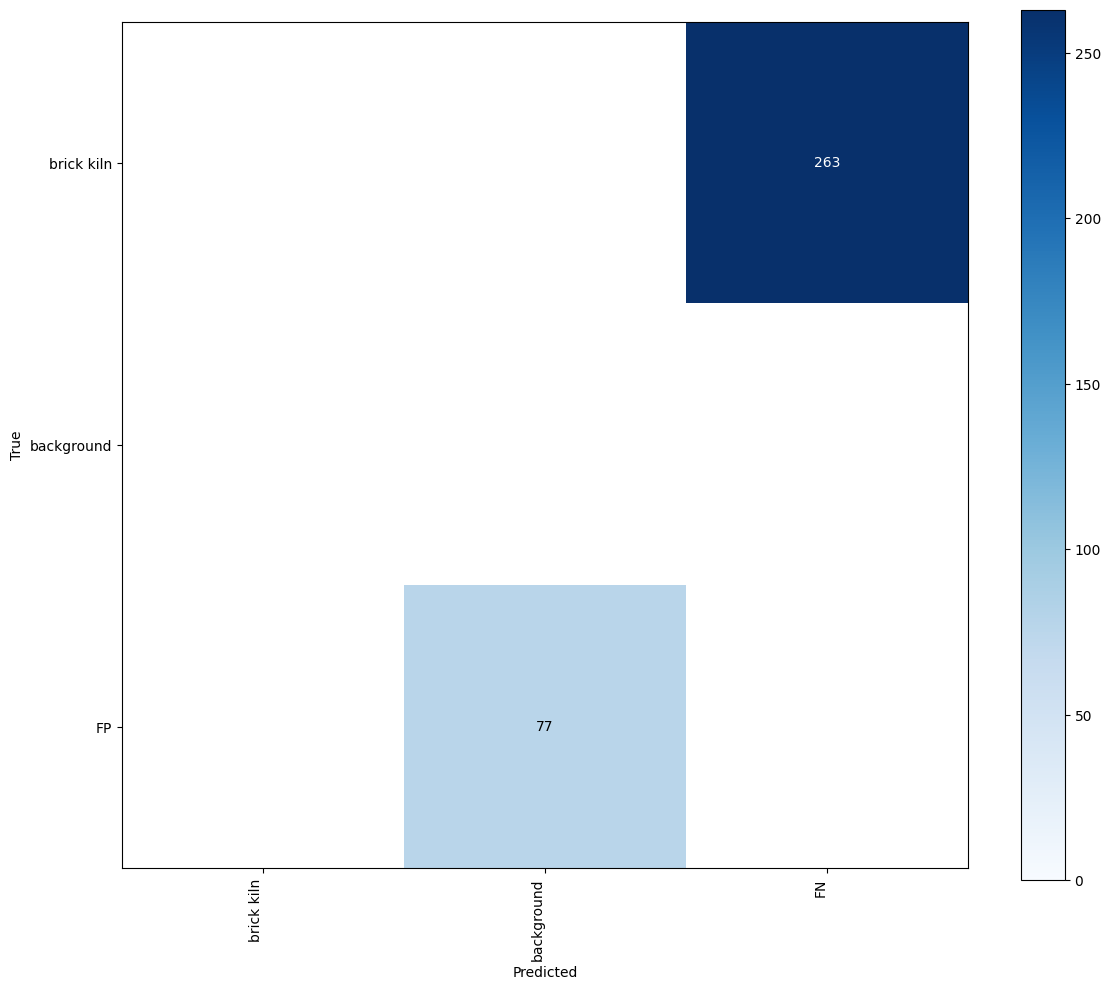

In [49]:
import os
import supervision as sv

# remove all predictions with confidence less than 0.3
target_results = []
predicted_results = []
conf_threshold = 0.25
# predicted_label_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yolo/predict/lucknow_obb_v_200_400__320_100/lucknow/labels'
# groundtruth_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/labels'
predicted_label_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yolo/predict/wb_small_airshed_obb_v_1_2__320_100/wb/labels'
groundtruth_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/west_bengal_class_agnostic/labels'
labels_path = glob(groundtruth_path+'/*')

for label_path in labels_path:
    bboxes = np.loadtxt(label_path, ndmin = 2)
    xmin = bboxes[:, [1,3,5,7]].min(axis = 1)
    xmax = bboxes[:, [1,3,5,7]].max(axis = 1)
    ymin = bboxes[:, [2,4,6,8]].min(axis = 1)
    ymax = bboxes[:, [2,4,6,8]].max(axis = 1)
    bboxes = np.array([xmin, ymin, xmax, ymax, bboxes[:, 0]])
    target_results.append(bboxes.T)
    label_file = os.path.basename(label_path)
    predicted_label_file = os.path.join(predicted_label_path, label_file)
    if not os.path.exists(predicted_label_file):
        predicted_results.append(np.array([[0, 0, 320, 320, 1, 1]])) # background class = 1, confidence = 1
    else:
        bboxes = np.loadtxt(predicted_label_file, ndmin = 2)
        bboxes = bboxes[bboxes[:,-1] >= conf_threshold]
        xmin = bboxes[:, [1,3,5,7]].min(axis = 1)
        xmax = bboxes[:, [1,3,5,7]].max(axis = 1)
        ymin = bboxes[:, [2,4,6,8]].min(axis = 1)
        ymax = bboxes[:, [2,4,6,8]].max(axis = 1)
        bboxes = np.array([xmin, ymin, xmax, ymax, bboxes[:, 0], bboxes[:, -1]])
        predicted_results.append(bboxes.T)

for pred_path in glob(predicted_label_path+'/*'):
    predicted_label_file = os.path.basename(pred_path)
    bboxes = np.loadtxt(pred_path, ndmin = 2)
    bboxes = bboxes[bboxes[:,-1] >= conf_threshold]

    label_file = groundtruth_path + '/' + predicted_label_file
    if not os.path.exists(label_file):
        xmin = bboxes[:, [1,3,5,7]].min(axis = 1)
        xmax = bboxes[:, [1,3,5,7]].max(axis = 1)
        ymin = bboxes[:, [2,4,6,8]].min(axis = 1)
        ymax = bboxes[:, [2,4,6,8]].max(axis = 1)
        bboxes = np.array([xmin, ymin, xmax, ymax, bboxes[:, 0], bboxes[:, -1]])
        predicted_results.append(bboxes.T)
        target_results.append(np.array([[0, 0, 320, 320, 1]])) # background class = 1, confidence = 1

df = pd.DataFrame({}, columns = ['IoU', 'Precision', 'Recall', 'F1 score', 'TP', 'FP', 'FN', 'Kiln instances'])
for iou in [0.1,0.3,0.5,0.7]:
    confusion_matrix = sv.ConfusionMatrix.from_tensors(predicted_results, target_results, classes = ['brick kiln', 'background'], conf_threshold=0.25, iou_threshold=iou)
    cm = confusion_matrix.matrix
    tp = cm[0][0]
    predicted_positives = cm[:,0].sum()
    actual_positives = cm[0, :].sum()
    precision = tp/ (predicted_positives + 1e-9)
    recall = tp/ (actual_positives + 1e-9)
    f1_score = 2*precision*recall / (precision + recall +1e-9)
    false_positives = predicted_positives - tp
    df = pd.concat([df, pd.DataFrame({'IoU': iou, 'Precision': precision, 'Recall': recall, 'F1 score': f1_score, 'TP': tp, 'FP': false_positives, 'FN': actual_positives - tp, 'Kiln instances': actual_positives}, index = [0])])

display(df)
_ = confusion_matrix.plot()

In [ ]:
# from PIL import Image
# img = Image.open('/home/shataxi.dubey/shataxi_work/vlm_on_planet/uttar_pradesh_high_resolution_zoom17/8594276_3380960.tif')
# img.save('UP_Zoom_17.png'), 'PNG'

(None, 'PNG')